# 04. Exploring the impact of cyclones on vegetation: vegetation recovery after event using a hovmoller plot

This notebook uses a hovmoller plot to visually examine the change in NDVI from before and after a tropical cyclone, and then the potential recovery of vegetation after the event. An interactive Landsat image allows the user to choose a cross section of the landscape. The notebook then calculates NDVI and plots the NDVI values for that cross section through time; therefore, allowing the user to see whether the tropical cyclone has impacted NDVI values for that landscape and the potential vegetation recovery timing.

Cells titled "user requirement" indicate where users are required to edit code, the remaining code should be run normally.

Code written in Janurary 2018 by Erin Telfer with support from Claire Krause. The notebook was completed as a graduate program project at Geoscience Australia. If you have comment or if you find an error, please contact erin.telfer@ga.gov.au. Alternatively, please contact Claire.Krause@ga.gov.au.

# Import libraries

In [58]:
#Import libraries 

%pylab notebook
import pandas as pd
import xarray as xr
from datetime import date, timedelta

import datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict

from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets

dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


# User requirement: specify directory locations

In [59]:
###User input: enter the directory location of input data. Ensure "/" are used, not "\"
input_folder = '/g/data/w85/ext547/input_data/'

###User input: enter the directory location of output data. Please enter again if the same as input_folder. Ensure "/" are used, not "\"
output_folder = '/g/data/w85/ext547/cyclone_repo/output_data/'

# User requirement: specifiy location of interest and details about cyclone

In [60]:
##User input: enter area of interest

# High Mt QLD Debbie
lat_min = -20.375 #down
lat_max = -20.340 #up
lon_min = 148.757 #left
lon_max = 148.806 #right

##User input: enter the name of vegetation of interest, e.g. "forest" or "banana crop"
vegetation_type = 'forest'

##User input: enter the name of the area/region/place/location of interest, e.g. "Hamilton Island"
location_name = 'High Mountain'

###User input: enter start and end date of cyclone
start_of_event= '2017-03-23'
end_of_event= '2017-04-07'

###User input: enter the name of cyclone
cyclone_name =  'Debbie'

###User input: set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. Scenes will not be retrieved that have less than the cloud threshold worth of image.
#The default value is "0.90" or >90% image and <10% cloud cover
cloud_free_threshold = 0.80 

# Datacube query is completed

In [61]:
#Temporal range, wavelengths/band and sensors of interest are defined

#temporal range is defined
start_of_epoch = '2010-01-01'
end_of_epoch =  '2017-12-31'

#wavelengths/bands of interest are defined
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Landsat sensors of interest are defined
sensors = ['ls8',
       'ls7',
      'ls5'] 

#query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2010-01-01', '2017-12-31'), 'x': (148.448, 148.629), 'y': (-20.318, -20.435), 'crs': 'EPSG:4326'}


In [62]:
#Reformat variables

start_of_event=datetime.datetime.strptime(start_of_event,'%Y-%m-%d') #Convert to datetime
end_of_event=datetime.datetime.strptime(end_of_event,'%Y-%m-%d') #Convert to datetime
location_name=location_name.replace(" ","_") #replace spaces with underscore

# Extract information from Open Data Cube

The extracted data is first filtered using the criteria in "mask_components". 
The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_free_threshold" are discarded.
Additionally, any pixel that is located within the ocean/sea will be converted to "nan" values with the 'land_sea' command.

In [63]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results. It should be noted the "land_sea" code will remove all ocean/sea pixels.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True,
'land_sea':'land'}

In [64]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}

for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        
    #Discard data that does not meet the cloud_free_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [65]:
#Check the output

sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 8, x: 814, y: 615)
 Coordinates:
   * time     (time) datetime64[ns] 2010-10-24T23:54:42.500000 ...
   * y        (y) float64 -2.289e+06 -2.289e+06 -2.289e+06 -2.289e+06 ...
   * x        (x) float64 1.702e+06 1.702e+06 1.702e+06 1.702e+06 1.703e+06 ...
 Data variables:
     green    (time, y, x) float64 721.0 752.0 815.0 721.0 721.0 784.0 815.0 ...
     red      (time, y, x) float64 705.0 828.0 779.0 730.0 730.0 803.0 828.0 ...
     nir      (time, y, x) float64 2.6e+03 2.665e+03 2.762e+03 2.665e+03 ...
     swir1    (time, y, x) float64 2.789e+03 2.941e+03 2.897e+03 2.919e+03 ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5'
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 41, x: 814, y: 615)
 Coordinates:
   * time     (time) datetime64[ns] 2010-02-02T23:56:36.500000 ...
   * y        (y) float64 -2.289e+06 -2.289e+06 -2.289e+06 -2.289e+06 ...
   * x        (x) float64 1.702e+

In [66]:
#Concatenate (join) data from different sensors together and sort so that observations are sorted by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), 'time')
nbar_clean = nbar_clean.sortby('time')
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [67]:
#Check that the concatenation worked

nbar_clean

<xarray.Dataset>
Dimensions:  (time: 92, x: 814, y: 615)
Coordinates:
  * y        (y) float64 -2.289e+06 -2.289e+06 -2.289e+06 -2.289e+06 ...
  * x        (x) float64 1.702e+06 1.702e+06 1.702e+06 1.702e+06 1.703e+06 ...
  * time     (time) datetime64[ns] 2010-02-02T23:56:36.500000 ...
Data variables:
    green    (time, y, x) float64 621.0 676.0 639.0 621.0 639.0 658.0 676.0 ...
    red      (time, y, x) float64 664.0 728.0 680.0 664.0 728.0 807.0 807.0 ...
    nir      (time, y, x) float64 2.631e+03 2.592e+03 2.437e+03 2.281e+03 ...
    swir1    (time, y, x) float64 2.709e+03 2.665e+03 2.665e+03 2.775e+03 ...
    product  (time) <U3 'ls7' 'ls7' 'ls7' 'ls7' 'ls5' 'ls5' 'ls7' 'ls7' ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 1702400.00|\n| 0.00,-25.00,-2289300.00|\n| 0.00,...

In [68]:
#calculate NDVI and only all use values >0 (i.e. removing water values of <0.0)
all_ndvi_sorted = ((nbar_clean.nir - nbar_clean.red)/(nbar_clean.nir + nbar_clean.red))
all_ndvi_sorted=all_ndvi_sorted.where(all_ndvi_sorted>=0.0)

# Show landscape prior to cyclone

## User requirement: run the next two cells to create an image and then click on a location to create a cross section along the x coordinate 

In [69]:
#Prepare imagery for scene before cyclone

rgb = nbar_clean.sel(time =start_of_event, method = 'pad').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


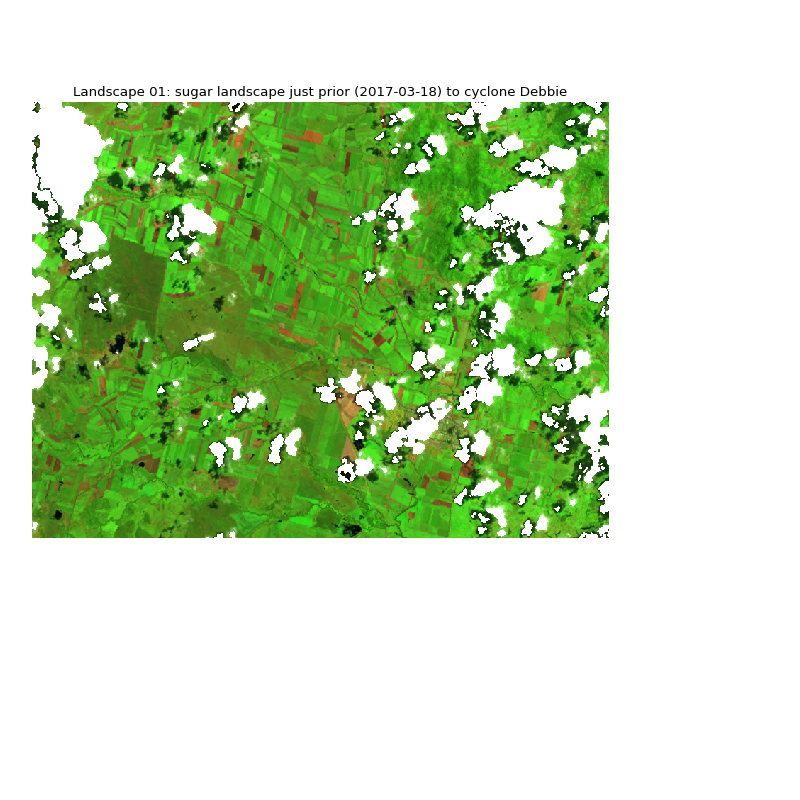

HTML(value='Event information appears here when you click on the figure')

In [70]:
#Click on this image to chose the location for time series extraction
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(8,8))
plt.imshow(scaled, interpolation = 'nearest')
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white 
fig.patch.set_alpha(0.99)#Ensure border white

plt.axis('off')#remove axis 
fig.canvas.mpl_connect('button_press_event', callback)
plt.title('Landscape 01: ' + str(vegetation_type)+ ' landscape just prior ('+ str(scaled.time.values)[0:10] +') to cyclone '+ str(cyclone_name)) #add title
plt.show()
display(w)

In [71]:
#Save figure
plt.savefig(str(output_folder)+'NB04_1_landscape_image01_'+str(cyclone_name)+'_'+str(location_name)+'_'+ str(scaled.time.values)[0:10])

In [72]:
#this converts the map x coordinate into image x coordinates
image_coords =(x, y)
imagex = int(image_coords[0])
imagey = int(image_coords[1])

ndvi_of_interest= all_ndvi_sorted.sel(time = start_of_event, method='pad')

# Create NDVI image with cross section highlighted

<IPython.core.display.Javascript object>


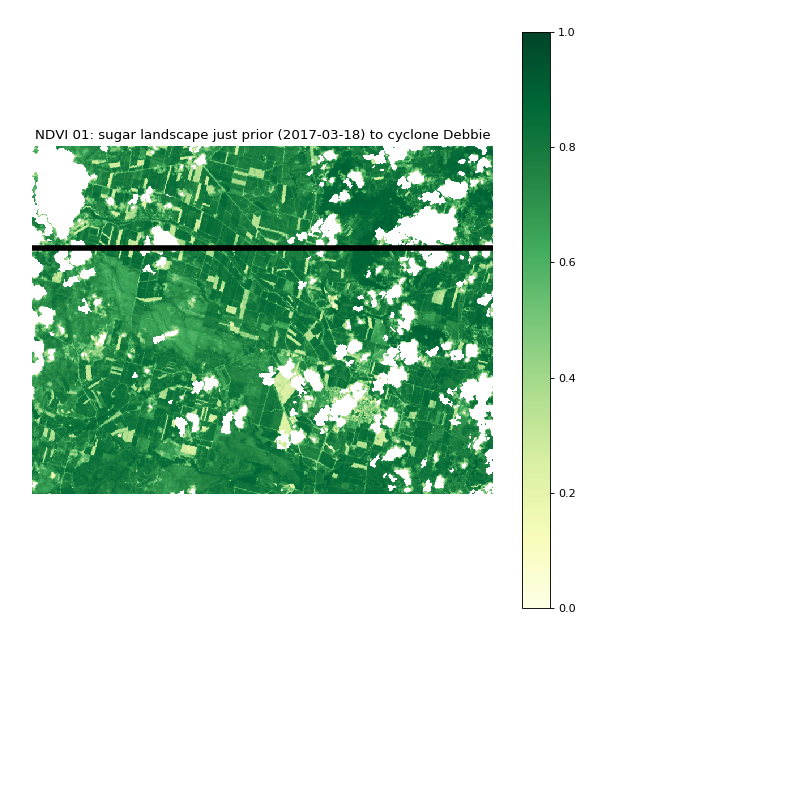

(-0.5, 813.5, 614.5, -0.5)

In [73]:
#Controls for NDVI colour map

fig = plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white 
fig.patch.set_alpha(0.99)#Ensure border white
i=plt.imshow(ndvi_of_interest,interpolation = 'nearest', cmap = 'YlGn', vmin=0,vmax=1) #create image with colourbar
fig.colorbar(i) #add colourbar
plt.title('NDVI 01: ' + str(vegetation_type)+ ' landscape just prior ('+ str(scaled.time.values)[0:10] +') to cyclone '+ str(cyclone_name)) #add title
# plt.plot([0, ndvi_of_interest.x.values.max()], [all_ndvi_sorted.y[imagey].values,all_ndvi_sorted.y[imagey].values], 'k', linewidth=5)
plt.plot([0, (ndvi_of_interest.shape[1]-1)], [imagey,imagey], 'k', linewidth=5)

plt.axis('off')#remove axis

In [74]:
#Save figure
plt.savefig(str(output_folder)+'NB04_2_NDVI_cross_section_'+str(cyclone_name)+'_'+str(location_name)+'_'+ str(scaled.time.values)[0:10])

# Create hovmoller plot of NDVI for cross section over time

<IPython.core.display.Javascript object>


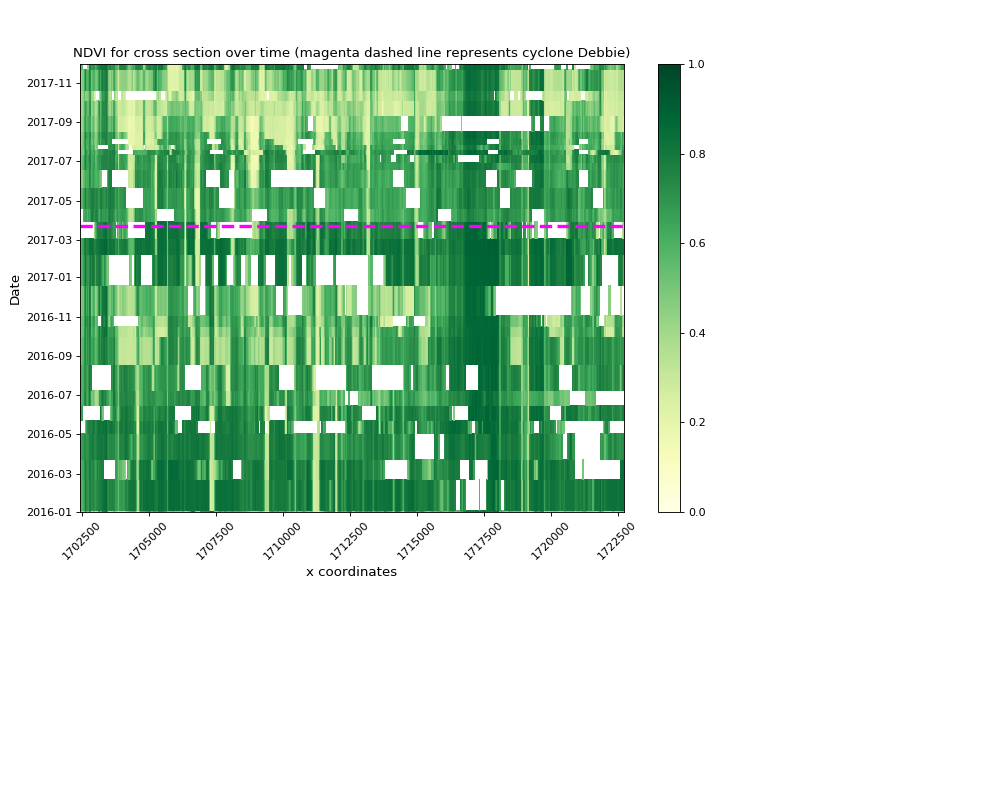

Text(0.5,1,'NDVI for cross section over time (magenta dashed line represents cyclone Debbie)')

In [77]:
#Hovmoller plot for the x transect

fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(left=0.10, right=0.95, top=0.90, bottom=0.20) #Set border dimensions
fig.patch.set_facecolor('white') #Make border is white
fig.patch.set_alpha(0.99) #Ensure border is white

# plt.plot([all_ndvi_sorted.x.min(), all_ndvi_sorted.x.max()], [np.datetime64('2017-01-01'),np.datetime64('2017-12-30')], '#FF00FF',linestyle='--', linewidth=3)

plt.plot([all_ndvi_sorted.x.min(), all_ndvi_sorted.x.max()], [start_of_event,start_of_event], '#FF00FF',linestyle='--', linewidth=3)
all_ndvi_sorted.isel(y=[imagey]).plot(cmap = 'YlGn',vmin = 0, vmax = 1)
plt.axis([all_ndvi_sorted.x.min(), all_ndvi_sorted.x.max(),np.datetime64('2016-01-01'),np.datetime64('2017-11-30')], 'tight')


plt.ylabel('Date', size=12) #Set Y label
plt.xlabel('x coordinates', size=12) #Set X label
plt.yticks(size=10) #Rotate and format size of date labels ##User should format if required
plt.xticks(rotation=45,size=10) #Rotate and format size of date labels ##User should format if required

plt.title('NDVI for cross section over time (magenta dashed line represents cyclone '+cyclone_name+')')

In [78]:
#Save figure
plt.savefig(str(output_folder)+'NB04_3_hovmoller_zoomed_'+str(cyclone_name)+'_'+str(location_name))